In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [19]:
class ImprovedTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, 
                 num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024, 
                 dropout=0.1):
        super(ImprovedTransformer, self).__init__()
        
        self.d_model = d_model
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout)
        
        # Transformer components
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        
        # Output layer
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)
        
        self._init_weights()
    
    def _init_weights(self):
        """Khởi tạo weights"""
        nn.init.normal_(self.src_embedding.weight, mean=0, std=0.02)
        nn.init.normal_(self.tgt_embedding.weight, mean=0, std=0.02)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, src, src_mask=None, src_key_padding_mask=None):
        """Encode source sequence"""
        src_embedded = self.src_embedding(src) * math.sqrt(self.d_model)
        src_embedded = self.pos_encoder(src_embedded)
        return self.encoder(src_embedded, src_mask, src_key_padding_mask)
    
    def decode(self, tgt, memory, tgt_mask=None, memory_mask=None, 
               tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """Decode target sequence"""
        tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_embedded = self.pos_decoder(tgt_embedded)
        return self.decoder(tgt_embedded, memory, tgt_mask, memory_mask,
                          tgt_key_padding_mask, memory_key_padding_mask)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, 
                src_padding_mask=None, tgt_padding_mask=None):
        """Forward pass hoàn chỉnh"""
        # Encode
        memory = self.encode(src, src_mask, src_padding_mask)
        
        # Decode
        output = self.decode(tgt, memory, tgt_mask, None,
                           tgt_padding_mask, src_padding_mask)
        
        return self.output_layer(output)

def generate_square_subsequent_mask(sz, device):
    """Tạo causal mask cho decoder"""
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask.to(device)

def create_masks(src, tgt, pad_idx, device):
    """Tạo masks"""
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)
    
    # Padding masks
    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)
    
    # Causal mask cho decoder
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    
    return src_padding_mask, tgt_padding_mask, tgt_mask

In [20]:
class BetterTranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=50):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        self.pad_idx = src_vocab['<pad>']
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        # Xử lý source
        src_words = self.src_sentences[idx].lower().split()
        src_indices = [self.src_vocab['<sos>']] + [
            self.src_vocab.get(word, self.src_vocab['<unk>']) for word in src_words
        ] + [self.src_vocab['<eos>']]
        
        # Xử lý target
        tgt_words = self.tgt_sentences[idx].split()
        tgt_indices = [self.tgt_vocab['<sos>']] + [
            self.tgt_vocab.get(word, self.tgt_vocab['<unk>']) for word in tgt_words
        ] + [self.tgt_vocab['<eos>']]
        
        # Padding/truncation
        src_indices = self._pad_sequence(src_indices)
        tgt_indices = self._pad_sequence(tgt_indices)
        
        return torch.tensor(src_indices), torch.tensor(tgt_indices)
    
    def _pad_sequence(self, sequence):
        if len(sequence) < self.max_len:
            return sequence + [self.pad_idx] * (self.max_len - len(sequence))
        else:
            return sequence[:self.max_len]

In [21]:
class OptimizedTrainer:
    def __init__(self, model, train_loader, val_loader, device, pad_idx):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.pad_idx = pad_idx
        
        # Loss function với label smoothing
        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)
        
        # Optimizer
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=0.001,
            betas=(0.9, 0.98), 
            eps=1e-9,
            weight_decay=0.01
        )
        
        # Scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50)
        
        self.train_losses = []
        self.val_losses = []
    
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        num_batches = len(self.train_loader)
        
        for batch_idx, (src, tgt) in enumerate(self.train_loader):
            src, tgt = src.to(self.device), tgt.to(self.device)
            
            # Tạo masks
            src_padding_mask, tgt_padding_mask, tgt_mask = create_masks(
                src, tgt[:, :-1], self.pad_idx, self.device
            )
            
            # Chuẩn bị data
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(
                src, tgt_input,
                src_padding_mask=src_padding_mask,
                tgt_mask=tgt_mask,
                tgt_padding_mask=tgt_padding_mask
            )
            
            # Tính loss
            loss = self.criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            self.optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}/{num_batches}, Loss: {loss.item():.4f}')
        
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        self.scheduler.step()
        
        return avg_loss
    
    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        num_batches = len(self.val_loader)
        
        with torch.no_grad():
            for src, tgt in self.val_loader:
                src, tgt = src.to(self.device), tgt.to(self.device)
                
                src_padding_mask, tgt_padding_mask, tgt_mask = create_masks(
                    src, tgt[:, :-1], self.pad_idx, self.device
                )
                
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]
                
                output = self.model(
                    src, tgt_input,
                    src_padding_mask=src_padding_mask,
                    tgt_mask=tgt_mask,
                    tgt_padding_mask=tgt_padding_mask
                )
                
                loss = self.criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
                total_loss += loss.item()
        
        avg_loss = total_loss / num_batches
        self.val_losses.append(avg_loss)
        
        print(f'Validation - Epoch: {epoch}, Loss: {avg_loss:.4f}')
        return avg_loss
    
    def train(self, num_epochs):
        print("Bắt đầu huấn luyện Transformer tối ưu...")
        
        best_val_loss = float('inf')
        
        for epoch in range(1, num_epochs + 1):
            train_loss = self.train_epoch(epoch)
            val_loss = self.validate(epoch)
            
            train_ppl = math.exp(min(train_loss, 10))
            val_ppl = math.exp(min(val_loss, 10))
            
            print(f'Epoch {epoch}:')
            print(f'  Train Loss: {train_loss:.4f}, PPL: {train_ppl:.2f}')
            print(f'  Val Loss: {val_loss:.4f}, PPL: {val_ppl:.2f}')
            print(f'  LR: {self.scheduler.get_last_lr()[0]:.2e}')
            print('-' * 50)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_transformer.pth')
                print(f'>>> Saved best model with val_loss: {val_loss:.4f}')
    
    def plot_training(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Curves')
        
        plt.subplot(1, 2, 2)
        train_ppl = [math.exp(loss) for loss in self.train_losses]
        val_ppl = [math.exp(loss) for loss in self.val_losses]
        plt.plot(train_ppl, label='Train PPL')
        plt.plot(val_ppl, label='Validation PPL')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity (log scale)')
        plt.legend()
        plt.title('Perplexity Curves')
        
        plt.tight_layout()
        plt.show()

In [22]:
class ImprovedTranslator:
    def __init__(self, model, src_vocab, tgt_vocab, device, max_len=50):
        self.model = model
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.device = device
        self.max_len = max_len
        self.pad_idx = src_vocab['<pad>']
        
        self.tgt_idx2word = {idx: word for word, idx in tgt_vocab.items()}
    
    def translate(self, src_sentence, max_length=50):
        """Dịch câu với greedy decoding"""
        self.model.eval()
        
        # Tokenize source
        src_words = src_sentence.lower().split()
        src_indices = [self.src_vocab['<sos>']] + [
            self.src_vocab.get(word, self.src_vocab['<unk>']) for word in src_words
        ] + [self.src_vocab['<eos>']]
        
        # Padding
        if len(src_indices) < self.max_len:
            src_indices = src_indices + [self.pad_idx] * (self.max_len - len(src_indices))
        else:
            src_indices = src_indices[:self.max_len]
        
        src_tensor = torch.tensor(src_indices).unsqueeze(0).to(self.device)
        
        # Encode source
        with torch.no_grad():
            memory = self.model.encode(src_tensor)
            
            # Bắt đầu với <sos>
            tgt_indices = [self.tgt_vocab['<sos>']]
            
            for i in range(max_length):
                tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(self.device)
                
                # Tạo mask cho decoder
                tgt_mask = generate_square_subsequent_mask(len(tgt_indices), self.device)
                
                # Decode
                output = self.model.decode(tgt_tensor, memory, tgt_mask=tgt_mask)
                output = self.model.output_layer(output)
                
                # Lấy token tiếp theo
                next_token_probs = output[0, -1, :]
                next_token = torch.argmax(next_token_probs).item()
                
                tgt_indices.append(next_token)
                
                # Dừng nếu gặp <eos>
                if next_token == self.tgt_vocab['<eos>']:
                    break
        
        # Convert to text
        translated_words = []
        for idx in tgt_indices[1:]:  # Bỏ <sos>
            if idx == self.tgt_vocab['<eos>']:
                break
            word = self.tgt_idx2word.get(idx, '<unk>')
            if word not in ['<pad>', '<unk>']:
                translated_words.append(word)
        
        return ' '.join(translated_words) if translated_words else "Không thể dịch"

In [23]:
def create_vocabularies():
    """Tạo vocabularies với dữ liệu phong phú"""
    train_src = [
        "i love machine learning",
        "the weather is beautiful today",
        "artificial intelligence is amazing", 
        "hello how are you",
        "this is a good example",
        "what is your name",
        "where are you from",
        "thank you very much",
        "i want to learn english",
        "the cat is on the table",
        "we are studying deep learning",
        "this food tastes delicious",
        "he is a good teacher",
        "she loves reading books",
        "they play football every day",
        "i like to drink coffee",
        "the sun is shining brightly",
        "my favorite color is blue",
        "can you help me please",
        "have a nice day"
    ]
    
    train_tgt = [
        "tôi yêu học máy",
        "thời tiết hôm nay thật đẹp",
        "trí tuệ nhân tạo thật tuyệt vời",
        "xin chào bạn có khỏe không", 
        "đây là một ví dụ hay",
        "bạn tên là gì",
        "bạn đến từ đâu",
        "cảm ơn bạn rất nhiều",
        "tôi muốn học tiếng anh",
        "con mèo ở trên bàn",
        "chúng tôi đang học deep learning",
        "món ăn này rất ngon",
        "anh ấy là một giáo viên giỏi",
        "cô ấy thích đọc sách",
        "họ chơi bóng đá mỗi ngày",
        "tôi thích uống cà phê",
        "mặt trời đang chiếu sáng rực rỡ",
        "màu sắc yêu thích của tôi là xanh dương",
        "bạn có thể giúp tôi được không",
        "chúc bạn một ngày tốt lành"
    ]
    
    # Tạo vocab từ tất cả các từ
    all_src_words = set()
    for sentence in train_src:
        all_src_words.update(sentence.lower().split())
    
    all_tgt_words = set()
    for sentence in train_tgt:
        all_tgt_words.update(sentence.split())
    
    # Xây dựng vocab
    src_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    
    # Thêm từ vựng
    for i, word in enumerate(all_src_words, start=4):
        src_vocab[word] = i
        
    for i, word in enumerate(all_tgt_words, start=4):
        tgt_vocab[word] = i
    
    return src_vocab, tgt_vocab, train_src, train_tgt

Using device: cpu
Source vocab size: 72
Target vocab size: 91
Training samples: 20
Model parameters: 958,299
Bắt đầu huấn luyện Transformer tối ưu...
Epoch: 1, Batch: 0/3, Loss: 5.0813
Validation - Epoch: 1, Loss: 4.1424
Epoch 1:
  Train Loss: 4.8524, PPL: 128.04
  Val Loss: 4.1424, PPL: 62.95
  LR: 9.99e-04
--------------------------------------------------
>>> Saved best model with val_loss: 4.1424
Epoch: 2, Batch: 0/3, Loss: 4.1943
Validation - Epoch: 2, Loss: 3.7726
Epoch 2:
  Train Loss: 4.2171, PPL: 67.84
  Val Loss: 3.7726, PPL: 43.49
  LR: 9.96e-04
--------------------------------------------------
>>> Saved best model with val_loss: 3.7726
Epoch: 3, Batch: 0/3, Loss: 3.9371
Validation - Epoch: 3, Loss: 3.2875
Epoch 3:
  Train Loss: 3.8463, PPL: 46.82
  Val Loss: 3.2875, PPL: 26.77
  LR: 9.91e-04
--------------------------------------------------
>>> Saved best model with val_loss: 3.2875
Epoch: 4, Batch: 0/3, Loss: 3.4525
Validation - Epoch: 4, Loss: 2.6407
Epoch 4:
  Train Lo

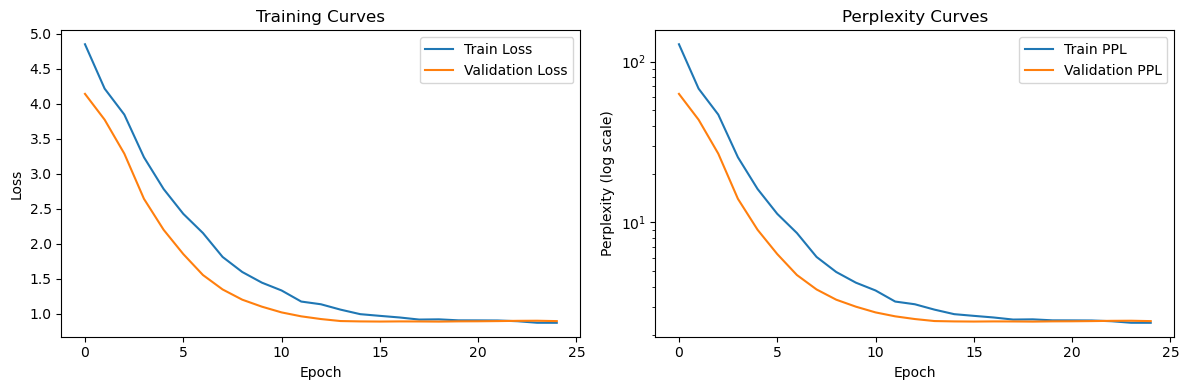

In [24]:
def main():
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Tạo dữ liệu
    src_vocab, tgt_vocab, train_src, train_tgt = create_vocabularies()
    
    print(f"Source vocab size: {len(src_vocab)}")
    print(f"Target vocab size: {len(tgt_vocab)}")
    print(f"Training samples: {len(train_src)}")
    
    # Tạo dataset
    train_dataset = BetterTranslationDataset(train_src, train_tgt, src_vocab, tgt_vocab, max_len=20)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
    
    # Khởi tạo model
    model = ImprovedTransformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        d_model=128,
        nhead=4,
        num_encoder_layers=2,
        num_decoder_layers=2, 
        dim_feedforward=512,
        dropout=0.1
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Huấn luyện
    trainer = OptimizedTrainer(model, train_loader, val_loader, device, pad_idx=src_vocab['<pad>'])
    trainer.train(num_epochs=25)
    
    # Vẽ đồ thị
    trainer.plot_training()

if __name__ == "__main__":
    main()